# Modelos de Clasificación

------------------------------------------------------


### Data Science and Machine Learning

#### Febrero 2023

**Aurora Cobo Aguilera**

**The Valley**

------------------------------------------------------

En un problema binario de clasificación, nos dan un vector de observaciones ${\bf x}\in \mathbb{R}^D$ que pertenece a una y sólo una *categoría* o *clase*, $y$, en el conjunto $Y = \{0, 1\}$. El objetivo de un clasificador es predecir el valor de $y$ basado en ${\bf x}$.

Para diseñar el clasificador, nos dan una colección de observaciones etiquetadas e i.i.d. $D = \{({\bf x}^{(n)}, y^{(n)})\}_{n=1}^N$ donde, para cada observación ${\bf x}^{(n)}$, el valor de su categoría real, $y^{(n)}$, es conocido. Todas las muestras son salidas independientes de una distribución desconocida $p({\bf x}, y)$.

In [ ]:
# Para visualizar gráficas en notebooks
%matplotlib inline 

#Importar algunas librerías que serán necesarias trabajando con datos y realizando gráficas
import csv     # Para leer archivos CSV
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split


## 1. Clasificación *k*-nearest neighbors (*k*NN)

En este notebook describiremos la siguiente tarea de clasificación que vamos a estudiar, el modelo *K*NN.

### 1.1. Cargamos el dataset Iris

La presentación del dataset Iris está basada en este <a href=http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/> Tutorial </a> de <a href=http://machinelearningmastery.com/about/> Jason Brownlee</a> 

Para ilustrar los algoritmos, consideraremos el <a href = http://archive.ics.uci.edu/ml/datasets/Iris> dataset Iris </a>, obtenido de <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository </a>. Citado de la descripción del dataset:

> Este es quizás el dataset más conocido en la literatura de reconocimiento de patrones. Contiene 3 clases de 50 muestras cada una, donde cada clase se refiere a un tipo de planta Iris. [...] Una clase es linealmente separable de las otras dos; las últimas no son linealmente separables entre ellas. 

La *clase* es la especie, que puede ser *setosa*, *versicolor* o *virginica*. Cada muestra contiene 4 medidas de las flores: longitud de sépalo, ancho de sépalo, longitud de pétalo y ancho de pétalo, todo en centímetros.

In [ ]:
data = pd.read_csv('iris.data', header=None)
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
 1   1       150 non-null    float64
 2   2       150 non-null    float64
 3   3       150 non-null    float64
 4   4       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


#### 1.2. Dividimos en conjuntos de entrenamiento y test

Lo siguiente es dividir los datos en conjuntos de entrenamiento, usado para aprender el modelo de clasificación, y de test, usado para evaluar la precisión del mismo.

Primero necesitamos convertir las medidas de las flores que se han cargado como strings en números con los que podamos trabajar. Lo siguiente, necesitamos dividir **aleatoriamente** en conjuntos de entrenamiento y test. Se usará una proporción del  67/33 para entrenamiento/test respectivamente.

El siguiente fragmento de código divide los datos aleatoriamente en conjuntos de entrenamiento y test usando la proporción dada. Pero antes, separa las variables de entrada de la salida, X e Y.

In [ ]:
X = data.iloc[:, :4]
Y = data.iloc[:, -1]

print(X.shape)
print(Y.shape)

(150, 4)
(150,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

In [ ]:
nTrain = len(X_train)
nTest = len(X_test)
print('Train: ' + str(nTrain))
print('Test: ' + str(nTest))

Train: 100
Test: 50


Usemos ahora dicha función para dividir los datos. Ten en cuenta que debido a la forma de repartir las muestras entre conjuntos, el número de muestras en cada partición podría ser diferente en ejecuciones diferentes del código si no fijaramos la semilla aleatoria, *random_state*.

### 1.3. Nos quedamos con un problema binario: Versicolor vs Virginica

A continuación, diseñaremos un clasificador para separar las clases "Versicolor" y "Virginica" usando $x_0$ y $x_1$ solo. Para ello construimos un conjunto de entrenamiento con las muestras de estas dos categorías, y una etiqueta binaria $y^{(k)} = 1$ para las de la clase "Virginica", y $0$ para las de "Versicolor".

In [ ]:
# Selecciona 2 clases
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'

train_filas_c0 = np.where(Y_train==c0)[0]
train_filas_c1 = np.where(Y_train==c1)[0]
test_filas_c0 = np.where(Y_test==c0)[0]
test_filas_c1 = np.where(Y_test==c1)[0]

# Coge el conjunto de entrenamiento
X_train_binario = np.array([X_train.iloc[n, :2] for n in range(nTrain) if ((n in train_filas_c0) or (n in train_filas_c1))])
Y_train_binario = np.array([int(Y_train.iloc[n]==c1) for n in range(nTrain) if ((n in train_filas_c0) or (n in train_filas_c1))])
n_tr = X_train_binario.shape[0]
print(X_train_binario.shape)
print(Y_train_binario.shape)


# Coge el conjunto de test
X_test_binario = np.array([X_test.iloc[n, :2] for n in range(nTest) if ((n in test_filas_c0) or (n in test_filas_c1))])
Y_test_binario = np.array([int(Y_test.iloc[n]==c1) for n in range(nTest) if ((n in test_filas_c0) or (n in test_filas_c1))])
n_tst = X_test_binario.shape[0]
print(X_test_binario.shape)
print(Y_test_binario.shape)

(66, 2)
(66,)
(34, 2)
(34,)


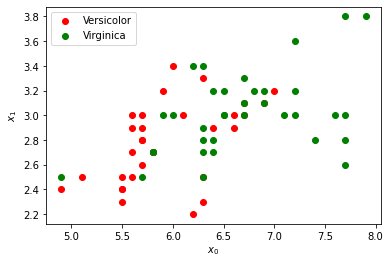

In [ ]:
# Separa las componentes de x en diferentes arrays (solo para las gráficas)
x0c0 = [X_train_binario[n][0] for n in range(n_tr) if Y_train_binario[n]==0]
x1c0 = [X_train_binario[n][1] for n in range(n_tr) if Y_train_binario[n]==0]
x0c1 = [X_train_binario[n][0] for n in range(n_tr) if Y_train_binario[n]==1]
x1c1 = [X_train_binario[n][1] for n in range(n_tr) if Y_train_binario[n]==1]

# Gráfico disperso.
labels = {'Iris-setosa': 'Setosa', 
          'Iris-versicolor': 'Versicolor',
          'Iris-virginica': 'Virginica'}
plt.scatter(x0c0, x1c0, color='r', label=labels[c0])
plt.scatter(x0c1, x1c1, color='g', label=labels[c1])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='best')
plt.show()


### 1.4. Clasificador baseline o de referencia: Maximum A Priori.

Para el dataset seleccionado tenemos dos clases con la siguiente proporción:

In [ ]:
print('Clase 0 (' + c0 + '): ' + str(n_tr - sum(Y_train_binario)) + ' muestras')
print('Clase 1 (' + c1 + '): ' + str(sum(Y_train_binario)) + ' muestras')

Clase 0 (Iris-versicolor): 31 muestras
Clase 1 (Iris-virginica): 35 muestras


El clasificador maximum a priori asigna cualquier muestra ${\bf x}$ a la clase más probable en el conjunto de entrenamiento. Por tanto, la predicción de clase $y$ para cualquier muestra ${\bf x}$ es

In [ ]:
y = int(2*sum(Y_train_binario) > n_tr)
print('y = ' + str(y) + ' (' + (c1 if y==1 else c0) + ')')

y = 1 (Iris-virginica)


La tasa de error para este baseline es:

In [ ]:
# Errores de entrenamiento y de test
E_tr = (Y_train_binario != y)
E_tst = (Y_test_binario != y)

# Tasas de error
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst
print('Pe(train) = ' + str(pe_tr))
print('Pe(test) = ' + str(pe_tst))

Pe(train) = 0.4696969696969697
Pe(test) = 0.5588235294117647


La tasa de error de un clasificador baseline es simplemente un punto de referencia para clasificación. Ya que el maximum a priori es independiente de la observación, ${\bf x}$, cualquier clasificador basado en ${\bf x}$ debería tener mejor (o, al menos, no peor) resultado que este baseline.

### 1.4. El clasificador Nearest-Neighbour (1-NN).

El clasificador 1-NN asigna cualquier muestra de entrada ${\bf x}$ a la categoría de su vecino más cercano en el conjunto de entrenamiento.
$$
d = f({\bf x}) = y^{(n)}, {\rm~where} \\
n = \arg \min_k \|{\bf x}-{\bf x}^{(k)}\|
$$

En caso de empate (i.e. hay más de una muestra a la misma distancia), la clase de una de ellas, cogida arbitrariamente, se asigna a ${\bf x}$.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Apliquemos el clasificador 1-NN al dataset dado. Primero, mostraremos las regiones de decisión del clasificador. Para ello, calculamos la salida del modelo para todos los puntos de una rejilla rectangular del espacio de las muestras.

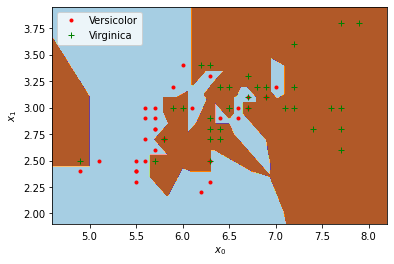

In [ ]:
# Crea una rejilla rectangular
x_min, x_max = X_train_binario[:, 0].min(), X_train_binario[:, 0].max() 
y_min, y_max = X_train_binario[:, 1].min(), X_train_binario[:, 1].max()
dx = x_max - x_min
dy = y_max - y_min
h = dy / 200
xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                     np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
X_grid = np.array([xx.ravel(), yy.ravel()]).T

# Calcula la salida del clasificador para todas las muestras de la rejilla
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train_binario, Y_train_binario)
Z_pred = KNN.predict(X_grid)

# Poner el resultado en un gráfico de colores
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='best')
Z_pred = Z_pred.reshape(xx.shape)
plt.contourf(xx, yy, Z_pred, cmap=plt.cm.Paired)
plt.show()

Podemos observar que la frontera de decisión del clasificador 1-NN es bastante intrincada, y puede contener pequeñas *islas* cubriendo una o varias muestras de una clase. De hecho, la extensión de estas pequeñas regiones usualmente se reduce cuando tenemos más muestras de entrenamiento, aunque la cantidad de éstas puede aumentar. 

A continuación calculamos la tasa de error en los conjuntos de entrenamiento y test.


In [ ]:
# Error de entrenamiento
Z_tr = KNN.predict(X_train_binario)
E_tr = Z_tr.flatten()!=Y_train_binario

# Error de test
Z_tst = KNN.predict(X_test_binario)
E_tst = Z_tst.flatten()!=Y_test_binario

# Tasas de error
pe_tr = np.mean(E_tr)
pe_tst = np.mean(E_tst)
print('Pe(train) = ' + str(pe_tr))
print('Pe(test) = ' + str(pe_tst))

Pe(train) = 0.09090909090909091
Pe(test) = 0.3235294117647059


Las tasas de error de entrenamiento y de test del clasificador 1-NN pueden ser significativamente diferentes. De hecho, el error de entrenamiento puede ser cercano a cero si las muestras no se superponen. En el problema seleccionado, este no es el caso, porque muestras de diferentes clases coinciden en el mismo punto, dando errores de clasificación en el entrenamiento. 

A pesar de que el clasificador 1-NN usualmente reduce el error con respecto al baseline, éste puede ser demasiado grande aún. Los errores se pueden deber a diferentes causas: 

   1. La distribución de clases está superpuesta ya que las variables seleccionadas no tienen información completa para discriminar entre clases: Esto implicaría que, incluso el mejor clasificador posible es propenso a errores.
   2. El conjunto de entrenamiento es pequeño y no suficientemente bueno para obtener una buena estimación del clasificador óptimo.
   3. El clasificador tiene limitaciones intrínsecas: a pesar de tener un número infinito de muestras, el rendimiento del clasificador no alcanza la solución óptima. 

En general, se dice que un clasificador es consistente si toma decisiones cercanas a la óptima conforme el número de muestras aumenta. De hecho, se puede demostrar que éste es el caso del clasificador 1-NN si el problema a tratar es separable, i.e. si existe una frontera de decisión con cero probabilidad de error. Desafortunadamente, en un caso no separable, el clasificador 1-NN no es consistente. Se puede demostrar que su error converge a un valor que no es peor que el doble del mínimo error alcanzable (Bayes error rate) cuando el número de muestras va a infinito.

### 1.5. El clasificador $k$-NN

Una simple extensión del clasificador 1-NN es el clasificador $k$-NN, que, para cualquier muestra de entrada ${\bf x}$, calcula los $k$ vecinos más cercanos del conjunto de entrenamiento y toma la clase mayoritaria en el subconjunto. Para evitar empates, se coge $k$ como un número impar.

(116358,)
(258, 451)
(116358, 2)


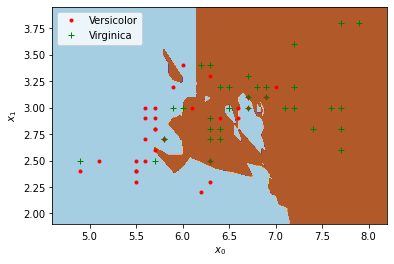

In [ ]:
k = 5

# Dibuja la frontera de decisión. Para eso, asignaremos un color a cada punto de la rejilla [x_min, m_max]x[y_min, y_max].
KNN_k = KNeighborsClassifier(n_neighbors=k)
KNN_k.fit(X_train_binario, Y_train_binario)
Z_pred = KNN_k.predict(X_grid)

# Ponemos el resultado en una grafica con colores
plt.plot(x0c0, x1c0, 'r.', label=labels[c0])
plt.plot(x0c1, x1c1, 'g+', label=labels[c1])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='best')

print(Z_pred.shape)
Z_pred = Z_pred.reshape(xx.shape)
print(Z_pred.shape)
print(X_grid.shape)
plt.contourf(xx, yy, Z_pred, cmap=plt.cm.Paired)
plt.show()

Podemos analizar la influencia del parámetro $k$ observando los errores de entrenamiento y de test.

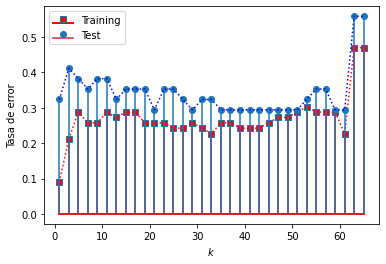

(66,)
(66,)


In [ ]:
# Dibujamos los errores de entrenamiento y de test en función del parámetro k
pe_tr = []
pe_tst = []
k_list = [2*n+1 for n in range(int(n_tr/2))]

for k in k_list:

    # Errores de entrenamiento
    KNN_k = KNeighborsClassifier(n_neighbors=k)
    KNN_k.fit(X_train_binario, Y_train_binario)
    Z_tr = KNN_k.predict(X_train_binario)
    E_tr = Z_tr.flatten()!=Y_train_binario

    # Errores de test
    Z_tst = KNN_k.predict(X_test_binario)
    E_tst = Z_tst.flatten()!=Y_test_binario

    # Tasas de error
    pe_tr.append(np.mean(E_tr))
    pe_tst.append(np.mean(E_tst))

# Ponemos los resultados en un gráfico con colores
markerline, stemlines, baseline = plt.stem(k_list, pe_tr,'r', markerfmt='s', label='Training')
plt.plot(k_list, pe_tr,'r:')
plt.setp(markerline, 'markerfacecolor', 'r', )
plt.setp(baseline, 'color','r', 'linewidth', 2)
markerline, stemlines, baseline = plt.stem(k_list, pe_tst, label='Test')
plt.plot(k_list, pe_tst,'b:')
plt.xlabel('$k$')
plt.ylabel('Tasa de error')
plt.legend(loc='best')
plt.show()

print(Z_tr.shape)
print(Y_train_binario.shape)

**Ejercicio**: Observa los errores de entrenamiento y test para valores grandes de $k$. Podrías relacionar la tasa de error del baseline con la del clasificador $k$-NN para algún valor de $k$? 

La figura de arriba sugiere que el valor óptimo de $k$ es

In [ ]:
i = np.argmin(pe_tst)
k_opt = k_list[i]
print('k_opt = ' + str(k_opt))

k_opt = 21


Sin embargo, usar el conjunto de test para seleccionar el valor óptimo del hiperparámetro $k$ no está permitido. En cambio, deberíamos recurrir a **cross validation**.




### 1.6. Selección de los hiperparámeteros via **cross-validation**

Un inconveniente de la aplicación del método $k$-nn es que la selección de $k$ influye el error final del algoritmo. En experimentos anteriores, vimos que la localización del mínimo no es necesariamente la misma desde la perspectiva de los datos de test. Idealmente, nos gustaría que el diseño del modelo de regresión funcione tan bien como sea posible para futuros patrones sin etiquetar que no están disponibles durante la fase de entrenamiento. Esta propiedad se llama <i>generalización</i>. Ajustamos los datos de entrenamiento con la esperanza de indirectamente obtener también un modelo que generalice bien. Para conseguir dicho objetivo, hay estrategias que intentan garantizar una correcta generalización del modelo. Una de dichas estrategias se conoce como validación cruzada o <b>cross-validation</b>, en inglés.

Ya que no se permite usar las etiquetas de test durante el entrenamiento (debería dejarse para simular posible aplicaciones futuras del modelo en patrones no observados), necesitamos averiguar una manera de mejorar nuestra estimación de los hiperparámetros que requiera solo datos de entrenamiento.Cross-validation nos permite hacer esto siguiendo una serie de pasos: 

   - Dividir el conjunto de entrenamiento en diferentes subconjuntos (generalmente no superpuestos). Si usamos $M$ subconjuntos, el método es definido como **$M$-fold cross-validation**. Si consideramos cada muestra como un conjunto diferente, el método es definido como **leave-one-out (LOO) cross-validation**.
   - Entrena el sistema $M$ veces. Para cada ejecución, usa diferentes particiones como el conunto de <i>validación</i>, y usa el resto como conjunto de entrenamiento. Evalua el rendimiento para diferentes elecciones del hiperparámetro (i.e., para diferentes valores de $k$ para el método $k$-NN).
   - Promedia el error de validación sobre todas las paritciones, y escoge el hiperparámetro que proporcione el mínimo error de validación.
   - Vuelve a ejecutar el algoritmo sobre todas las muestras de entrenamiento, manteniendo el valor del hiperparámetro que elegiste del proceso de cross-validation.


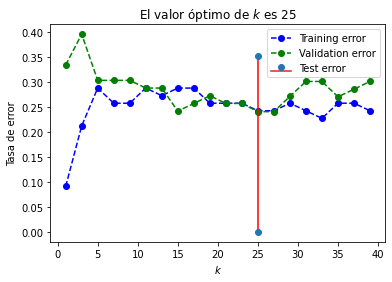

In [ ]:
## Este fragmento de código ejecuta k-nn validación cruzada con M subconjuntos

# Obtener el índice para los M subconjuntos
n_tr = X_train_binario.shape[0]
M = 5
permutation = np.random.permutation(n_tr)

# Inicializar los conjuntos de índices
set_indices = {n: [] for n in range(M)}

# Distribuir los datos entre los M subconjuntos
n = 0
for pos in range(n_tr):
    set_indices[n].append(permutation[pos])
    n = (n+1) % M

# Ahora ejecutamos el proceso de validación cruzada con el modelo k-nn
k_max = 40
k_list = [2*j+1 for j in range(int(k_max/2))]

# Obtener los errores de validación
pe_val = 0
for n in range(M):
    i_val = set_indices[n]
    i_tr = []
    for kk in range(M):
        if not n==kk:
            i_tr += set_indices[kk]
    
    pe_val_iter = []
    for k in k_list:
        KNN_k = KNeighborsClassifier(n_neighbors=k)
        KNN_k.fit(X_train_binario[i_tr], Y_train_binario[i_tr])
        y_tr_iter = KNN_k.predict(X_train_binario[i_val])
        pe_val_iter.append(np.mean(Y_train_binario[i_val] != y_tr_iter))

    pe_val = pe_val + np.asarray(pe_val_iter)

pe_val = pe_val / M

# Calcular las curvas de error de entrenamiento y de validación
pe_tr = [np.mean(Y_train_binario != KNeighborsClassifier(n_neighbors=k).fit(X_train_binario, Y_train_binario).predict(X_train_binario).flatten()) for k in k_list] 

k_opt = k_list[np.argmin(pe_val)]
pe_tst = np.mean(Y_test_binario != KNeighborsClassifier(n_neighbors=k_opt).fit(X_train_binario, Y_train_binario).predict(X_test_binario).flatten())

plt.plot(k_list, pe_tr,'b--o',label='Training error')
plt.plot(k_list, pe_val.T,'g--o',label='Validation error')
plt.stem([k_opt, k_opt], [0, pe_tst],'r-o',label='Test error')
plt.legend(loc='best')
plt.title('El valor óptimo de $k$ es ' + str(k_opt))
plt.xlabel('$k$')
plt.ylabel('Tasa de error')
plt.show()


## 2. Implementación con Scikit-learn de todas las variables

Siguiendo el mismo proceso que con regresión, usaremos la librería de Scikit-learn en clasificación. La siguiente celda de código utiliza el método

    KNeighborsClassifier
    
para calcular el clasificador $k$-NN usando las 4 componentes del dataset original. 

Para ello, repetimos la selección de los datos, esta vez cogiendo todas las columnas de X.


In [ ]:
# Selecciona 2 clases
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'

train_filas_c0 = np.where(Y_train==c0)[0]
train_filas_c1 = np.where(Y_train==c1)[0]
test_filas_c0 = np.where(Y_test==c0)[0]
test_filas_c1 = np.where(Y_test==c1)[0]

# Coge el conjunto de entrenamiento
X_train_binario = np.array([X_train.iloc[n, :] for n in range(nTrain) if ((n in train_filas_c0) or (n in train_filas_c1))])
Y_train_binario = np.array([int(Y_train.iloc[n]==c1) for n in range(nTrain) if ((n in train_filas_c0) or (n in train_filas_c1))])
n_tr = X_train_binario.shape[0]
print(X_train_binario.shape)
print(Y_train_binario.shape)


# Coge el conjunto de test
X_test_binario = np.array([X_test.iloc[n, :] for n in range(nTest) if ((n in test_filas_c0) or (n in test_filas_c1))])
Y_test_binario = np.array([int(Y_test.iloc[n]==c1) for n in range(nTest) if ((n in test_filas_c0) or (n in test_filas_c1))])
n_tst = X_test_binario.shape[0]
print(X_test_binario.shape)
print(Y_test_binario.shape)

(66, 4)
(66,)
(34, 4)
(34,)


In [ ]:
k = 5

for weights in ['uniform', 'distance']:
    # Creamos una instancia del clasificador KNeighbours y entrenamos con los datos.
    clf = KNeighborsClassifier(k, weights=weights)
    clf.fit(X_train_binario, Y_train_binario)
    Y_test_pred = clf.predict(X_test_binario)
    pe_tst = np.mean(Y_test_binario != Y_test_pred)
    print('Tasa de error con ' + weights + ' weights = ' + str(pe_tst))


Tasa de error con uniform weights = 0.029411764705882353
Tasa de error con distance weights = 0.029411764705882353


<a href = http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html> Aquí</a> puedes encontrar un ejemplo de la aplicación de `KNeighborsClassifier` al problema completo de clasificación de las 3-clases del dataset de flores Iris.